In [2]:
import redis
import datetime

r = redis.Redis(host='redis-server', port=6379, db=0, decode_responses=True)

# EJERCICIO 1 — Cadenas, Contadores y Expiración

### Una aplicación quiere almacenar información básica.

1. Crea la clave app:version con el valor "2.0".

In [3]:
r.set('app:version', '2.0')

True

2. Crea un contador de descargas en **``app:downloads``** con valor inicial **``0``**.

In [4]:
r.set('app:downloads', '0')

True

3. Incrementa el contador en 3.

In [5]:
r.incrby("app:downloads", 3)
print("Contador despues: ", r.get('app:downloads'))

Contador despues:  3


4. Cambia la versión a **``"2.1"``**

In [6]:
r.set('app:version', '2.1')

True

5. Establece un tiempo de expiración de 30 segundos para **``app:version``**.

In [7]:
r.expire('app:version', 30)

True

In [8]:
print(r.get("app:version"))
print(r.get("app:downloads"))

2.1
3


# EJERCICIO 2 — Listas (cola de tareas)

### Una tienda online recibe pedidos y los coloca en una cola.

1. Inserta los pedidos **``"pedido_001"``**, **``"pedido_002"``**, **``"pedido_003"``** en la lista **``pedidos``** (en ese orden).

In [9]:
r.rpush("pedido", "pedido_001")
r.rpush("pedido", "pedido_002")
r.rpush("pedido", "pedido_003")

3

2. Muestra toda la lista.

In [10]:
print("Lista actual:", r.lrange("pedido", 0, -1))

Lista actual: ['pedido_001', 'pedido_002', 'pedido_003']


3. Inserta un pedido urgente "pedido_URGENTE" al inicio.

In [11]:
r.lpush("pedido", "pedido_URGENTE")

4

4. Procesa (elimina y muestra) dos pedidos.

In [12]:
print("Procesado:", r.lpop("pedido"))
print("Procesado:", r.lpop("pedido"))

Procesado: pedido_URGENTE
Procesado: pedido_001


5. Muestra el contenido restante de la lista.

In [13]:
print("Lista actual:", r.lrange("pedido", 0, -1))

Lista actual: ['pedido_002', 'pedido_003']


# EJERCICIO 3 — Hashes + Sorted Set (Ranking de jugadores)

### Gestiona la información de jugadores.

1. Crea la ficha del jugador 201:
- name = "Laura"
- country = "España"
- games_played = 0
- score = 800

In [14]:
r.hset("player:201", mapping={
    "name": "Laura", 
    "country": "España", 
    "games_played": 0, 
    "score": 800
})

4

2. Añádelo al ranking **``leaderboard``**.

In [15]:
r.zadd("leaderboard", {201: 800})

1

3. Incrementa el score del jugador 201 en 250 y suma 1 partida.

In [16]:
r.hincrby("player:201", "score", 250)
r.hincrby("player:201", "games_played", 1)

1

4. Actualiza su posición en el ranking.

In [17]:
nuevo_score = int(r.hget("player:201", "score"))
r.zadd("leaderboard", {201: nuevo_score})

0

5. Muestra toda la ficha del jugador.

In [18]:
r.hgetall("player:201")

{'name': 'Laura', 'country': 'España', 'games_played': '1', 'score': '1050'}

6. Obtén el TOP 1 del ranking.

In [19]:
print(r.zrevrange("leaderboard", 0, 0, withscores=True))

[('103', 1850.0)]


# EJERCICIO 4 — HyperLogLog (Usuarios únicos)

### Un sistema registra accesos de usuarios.

1. Registra que los usuarios 101, 102, 103 entraron el día **``2025-12-06``**.

In [20]:
r.pfadd("2025-12-06", 101)
r.pfadd("2025-12-06", 102)
r.pfadd("2025-12-06", 103)

1

2. Registra que los usuarios 102, 104 entraron el día **``2025-12-07``**.

In [21]:
r.pfadd("2025-12-07", 102)
r.pfadd("2025-12-07", 104)

1

3. Cuenta cuántos usuarios únicos hubo el día 2025-12-06.

In [22]:
r.pfcount("2025-12-06")

3

4. Combina ambos días en **``unique:players:week``**.
5. Muestra cuántos usuarios únicos hubo en total entre los dos días.

In [23]:
r.pfmerge("week", "2025-12-06", "2025-12-07")
r.pfcount("week")

4

# EJERCICIO 5 – Geo (Puntos de interés)

1. Insertar estos POIs en **``poi:locations``** y **``poi:info``**:
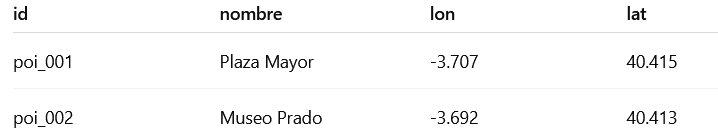

In [25]:
# Guardar coordenadas en la estructura GEO
r.geoadd("poi:locations", (-3.707, 40.415, "poi_001"))
r.geoadd("poi:locations", (-3.692, 40.413, "poi_002"))

# Guardar nombres en un hash
r.hset("poi:info", "poi_001", "Plaza Mayor")
r.hset("poi:info", "poi_002", "Museo Prado")


1

2. Buscar POIs a 1.5 km de:
- lat = 40.4167
- lon = -3.7038

In [26]:
poi_ids = r.geosearch(
    "poi:locations",
    longitude=-3.7038,
    latitude=40.4167,
    radius=1.5,
    unit="km"
)

3. Mostrar nombre e id de cada POI encontrado

In [27]:
for poi_id in poi_ids:
    name = r.hget("poi:info", poi_id)
    print(f"{name} ({poi_id})")

Plaza Mayor (poi_001)
Museo Prado (poi_002)


4. Obtener el POI más cercano (con distancia)

In [28]:
nearest = r.geosearch(
    "poi:locations",
    longitude=-3.7038,
    latitude=40.4167,
    unit="km",
    radius=10,       # radio grande para asegurarnos de pillarlos
    sort="ASC",      # ASC = del más cercano al más lejano
    count=1,         # solo queremos 1
    withdist=True    # que devuelva también la distancia
)
poi_id, dist = nearest[0]
name = r.hget("poi:info", poi_id)
print(f'El POI más cercano es "{name}" ({poi_id}), a {dist} km.')

El POI más cercano es "Plaza Mayor" (poi_001), a 0.3303 km.
